In [40]:
options(warn = -1)
pacotes <- c("tidyquant", "timetk", "dplyr", "ggplot2", "tidyr", "PortfolioAnalytics",
             "corrplot")
for(i in pacotes){
  library(i, character.only = T)
}

In [41]:
#Coletando os dados
acoes <- c("ITUB4.SA", "ITSA4.SA", "ENAT3.SA", "ABEV3.SA", "TRPL4.SA", "OIBR3.SA",
          "SEER3.SA", "PETR4.SA")
s <- tq_get(acoes, from = "2010-01-01")

In [42]:
#Mudando os dados
month_retun <- s %>%
  group_by(symbol) %>%
  tq_transmute(select = close, mutate_fun = periodReturn, period = "monthly")
daily_retunr <- s %>%
  group_by(symbol) %>%
  tq_transmute(select = close, mutate_fun = periodReturn, period = "daily")
retornos_m <- month_retun %>%
  mutate(year = year(date)) %>%
  group_by(symbol, year) %>%
  summarise(Retorno_Mensal_Médio = mean(monthly.returns),
            Desvio_Mensal = sd(monthly.returns)) %>%
  gather(Retorno_Mensal_Médio, Desvio_Mensal, key = statistic, value = value)
retornos <- daily_retunr %>%
  mutate(year = year(date)) %>%
  group_by(symbol, year) %>%
  summarise(Retorno_Diário = mean(daily.returns),
            Desvio_Padrão = sd(daily.returns)) %>%
  gather(Retorno_Diário, Desvio_Padrão, key = statistic, value = value)

`summarise()` regrouping output by 'symbol' (override with `.groups` argument)

`summarise()` regrouping output by 'symbol' (override with `.groups` argument)



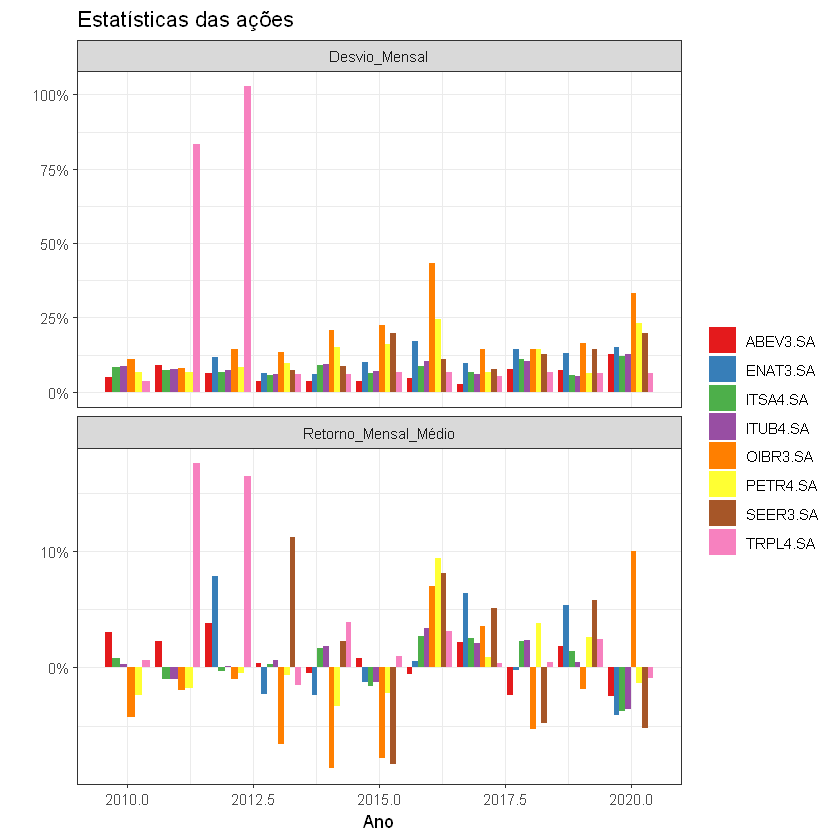

In [43]:
#Gráficos
retornos_m %>%
  ggplot(aes(year,value))+
  geom_col(aes(fill = symbol), position = "dodge")+
  scale_y_continuous(labels = scales::percent)+
  theme_bw()+
  scale_fill_brewer(palette = "Set1",
                    name = "")+
  facet_wrap(~statistic, scales = "free_y", nrow = 2)+
  labs(x = "Ano", y = "", title = "Estatísticas das ações")

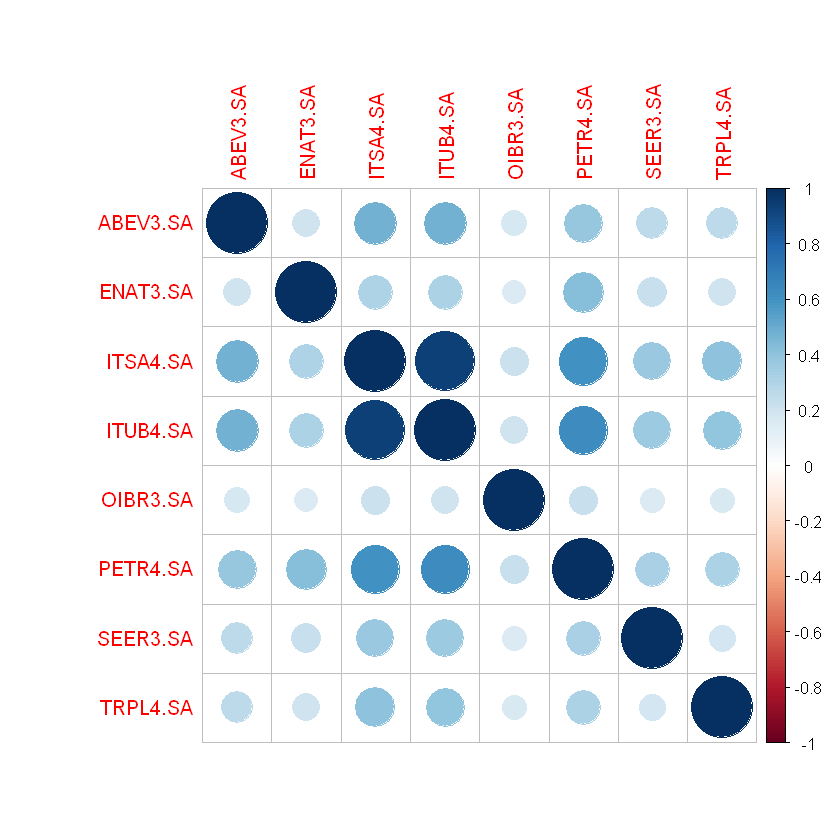

In [44]:
correlacao <- daily_retunr %>%
  spread(key = symbol, value = daily.returns) %>%
  na.omit()
correlacao <- cor(correlacao[,2:ncol(correlacao)])
corrplot(correlacao)

In [45]:
correlacao
min(correlacao)

,ABEV3.SA,ENAT3.SA,ITSA4.SA,ITUB4.SA,OIBR3.SA,PETR4.SA,SEER3.SA,TRPL4.SA
ABEV3.SA,1.0000000,0.2022731,0.4725177,0.4723089,0.1782238,0.3841869,0.2678412,0.2662048
ENAT3.SA,0.2022731,1.0000000,0.3065992,0.3147336,0.1540616,0.4263462,0.2252442,0.2061128
ITSA4.SA,0.4725177,0.3065992,1.0000000,0.9300578,0.2143242,0.6078676,0.3700971,0.4019364
ITUB4.SA,0.4723089,0.3147336,0.9300578,1.0000000,0.2088676,0.6253512,0.3650979,0.3921478
OIBR3.SA,0.1782238,0.1540616,0.2143242,0.2088676,1.0000000,0.2221789,0.1559265,0.1657997
PETR4.SA,0.3841869,0.4263462,0.6078676,0.6253512,0.2221789,1.0000000,0.3236855,0.3116463
SEER3.SA,0.2678412,0.2252442,0.3700971,0.3650979,0.1559265,0.3236855,1.0000000,0.1849484
TRPL4.SA,0.2662048,0.2061128,0.4019364,0.3921478,0.1657997,0.3116463,0.1849484,1.0000000


[1] 0.1540616